# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. 

В наличии размеченный набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Введение
Изучим датасет с фотографиями людей различных возрастов

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

In [2]:
# Загрузка датасета
df = pd.read_csv('/datasets/faces/labels.csv')
df.sample(5)


,file_name,real_age
1397,001397.jpg,50
3980,003980.jpg,61
2978,002978.jpg,16
4234,004234.jpg,55
4930,004930.jpg,51


In [3]:
# Общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [5]:
# Проверка одинаковых имен файлов
df['file_name'].duplicated().sum()

0

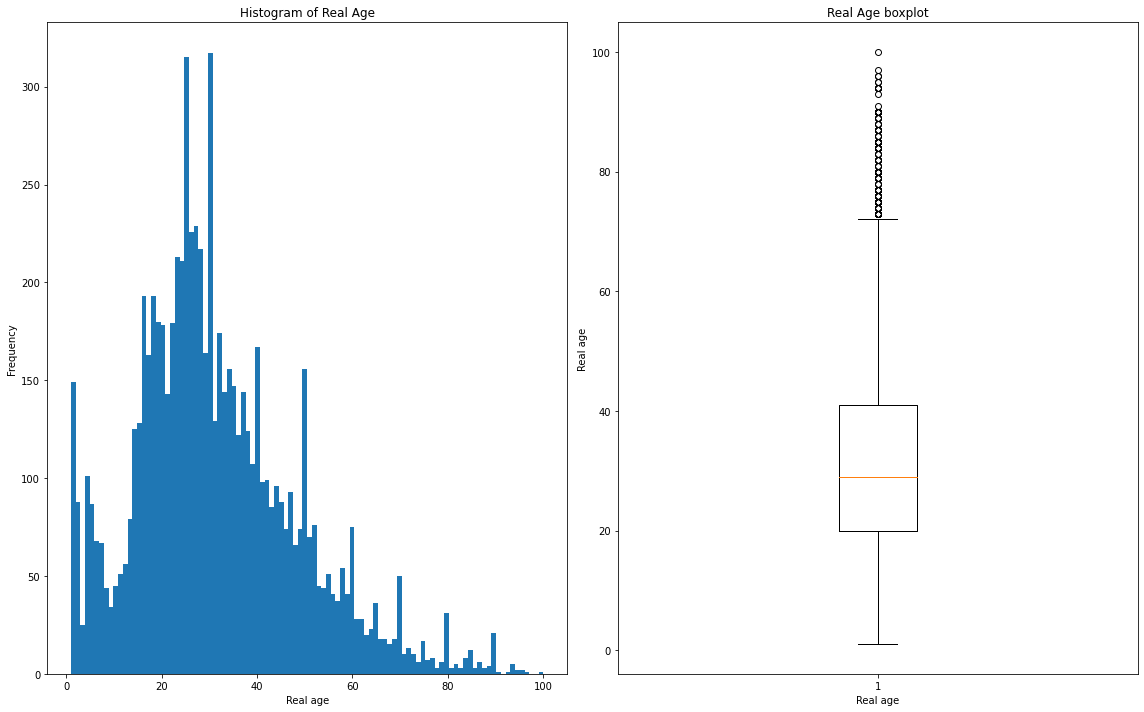

In [6]:
# Гистограмма и boxplot распределения возрастов
plt.figure(figsize=(16,10))

plt.subplot(1, 2, 1)  
plt.hist(df['real_age'], bins=100)
plt.xlabel('Real age')
plt.ylabel('Frequency')
plt.title('Histogram of Real Age')

plt.subplot(1, 2, 2)
plt.boxplot(df['real_age'])
plt.ylabel('Real age')
plt.xlabel('Real age')
plt.title('Real Age boxplot')

plt.tight_layout()
plt.show()


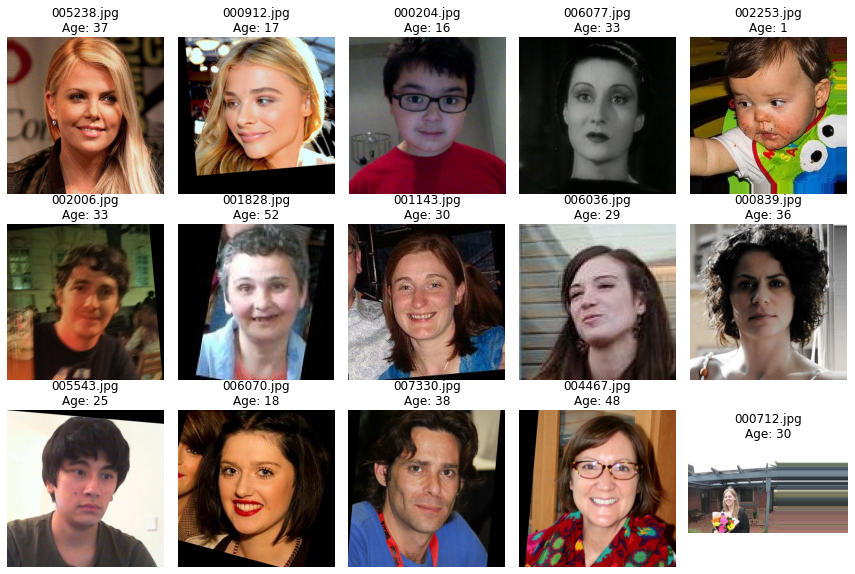

In [7]:
# Построим 15 случайных фотографий из всего датасета

file_names = df['file_name'].tolist()
real_ages = df['real_age'].tolist()

random.seed(42)  
selected_files = random.sample(file_names, 15)
selected_ages = [real_ages[file_names.index(file_name)] for file_name in selected_files] 

image_dir = '/datasets/faces/final_files/'

fig, axes = plt.subplots(3, 5, figsize=(12, 8))  

for idx, (file_name, age) in enumerate(zip(selected_files, selected_ages)):
    image_path = os.path.join(image_dir, file_name)

    image = Image.open(image_path)
    
    ax = axes[idx // 5, idx % 5]
    ax.imshow(image)
    ax.axis('off') 
    ax.set_title(f'{file_name}\nAge: {age}') 

plt.tight_layout() 
plt.show()


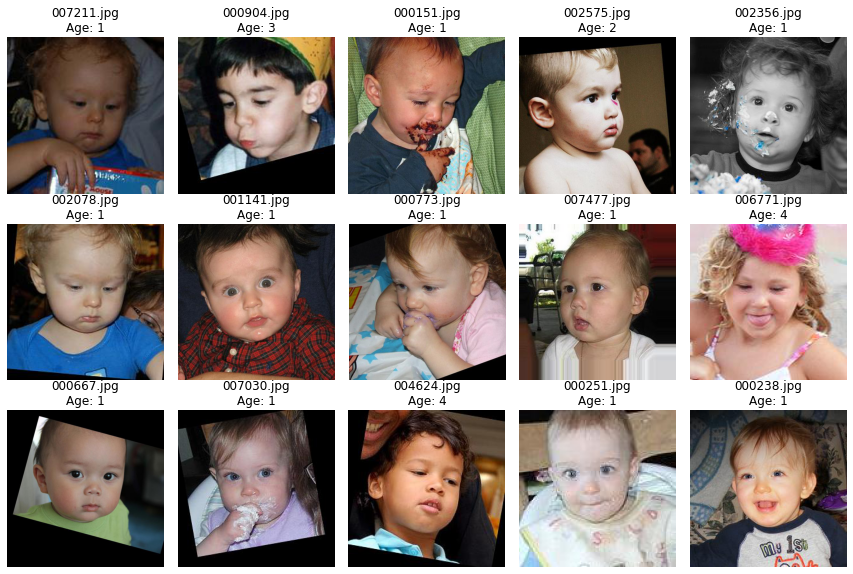

In [8]:
# Построим 15 случайных фотографий из возраста менее 5 лет

file_names = df[df['real_age'] < 5]['file_name'].tolist()
real_ages = df[df['real_age'] < 5]['real_age'].tolist()

random.seed(42)  
selected_files = random.sample(file_names, 15)
selected_ages = [real_ages[file_names.index(file_name)] for file_name in selected_files] 

image_dir = '/datasets/faces/final_files/'

fig, axes = plt.subplots(3, 5, figsize=(12, 8))  

for idx, (file_name, age) in enumerate(zip(selected_files, selected_ages)):
    image_path = os.path.join(image_dir, file_name)

    image = Image.open(image_path)
    
    ax = axes[idx // 5, idx % 5]
    ax.imshow(image)
    ax.axis('off') 
    ax.set_title(f'{file_name}\nAge: {age}') 

plt.tight_layout() 
plt.show()


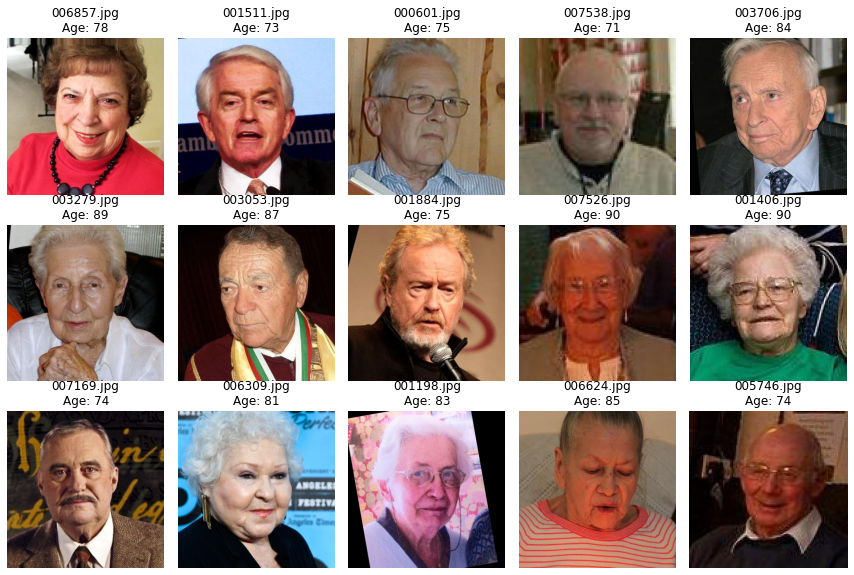

In [9]:
# Построим 15 случайных фотографий из возраста более 70 лет

file_names = df[df['real_age'] > 70]['file_name'].tolist()
real_ages = df[df['real_age'] > 70]['real_age'].tolist()

random.seed(42)  
selected_files = random.sample(file_names, 15)
selected_ages = [real_ages[file_names.index(file_name)] for file_name in selected_files] 

image_dir = '/datasets/faces/final_files/'

fig, axes = plt.subplots(3, 5, figsize=(12, 8))  

for idx, (file_name, age) in enumerate(zip(selected_files, selected_ages)):
    image_path = os.path.join(image_dir, file_name)

    image = Image.open(image_path)
    
    ax = axes[idx // 5, idx % 5]
    ax.imshow(image)
    ax.axis('off') 
    ax.set_title(f'{file_name}\nAge: {age}') 

plt.tight_layout() 
plt.show()


In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

### Вывод
Данные распределены неравномерно. Медианное значение 29 лет, среднее значение 31 год. В данных присутствует некоторое количество выбросов. Минимальный возраст 1 год, максимальный 100 лет. Можно предположить, что сеть, обученная на этих данных будет иметь худшие метрики на возрастах более 70 лет ввиду малого количества данных. 

## Обучение модели

In [ ]:
def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    labels = pd.read_csv(path + 'labels.csv')
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=8,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow 


def load_test(path):
    valid_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255.)

    labels = pd.read_csv(path + 'labels.csv')
    
    val_datagen_flow = valid_datagen.flow_from_dataframe(
        dataframe=labels,
        directory= path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=8,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return val_datagen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=(244, 244, 3), weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False) 
    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu')) 
    model.summary()

    optimizer = Adam(learning_rate =0.0005)

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae']) 
    return model


def train_model(model, train_data, test_data, batch_size = None, epochs=50,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
	      batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model


# Обучение модели
path = '/datasets/faces/'
input_shape=(244, 244, 3)
train_data = load_train(path)
test_data = load_test(path)
model = create_model(input_shape)
train_model(model, train_data, test_data)


```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 712 steps, validate for 238 steps
Epoch 1/50
712/712 - 262s - loss: 241.7393 - mae: 11.9200 - val_loss: 348.8461 - val_mae: 14.9734
Epoch 2/50
712/712 - 68s - loss: 168.3627 - mae: 10.0189 - val_loss: 313.5187 - val_mae: 13.1990
Epoch 3/50
712/712 - 61s - loss: 135.4894 - mae: 8.9978 - val_loss: 169.0043 - val_mae: 10.1619
Epoch 4/50
712/712 - 41s - loss: 107.1417 - mae: 7.9958 - val_loss: 188.2426 - val_mae: 10.9596
Epoch 5/50
712/712 - 41s - loss: 83.8126 - mae: 7.0674 - val_loss: 113.0556 - val_mae: 8.4026
Epoch 6/50
712/712 - 41s - loss: 59.0686 - mae: 5.9442 - val_loss: 174.2401 - val_mae: 9.6868
Epoch 7/50
712/712 - 41s - loss: 47.1758 - mae: 5.3164 - val_loss: 174.2118 - val_mae: 9.8918
Epoch 8/50
712/712 - 41s - loss: 39.2686 - mae: 4.8320 - val_loss: 133.2489 - val_mae: 8.9458
Epoch 9/50
712/712 - 41s - loss: 29.4089 - mae: 4.2100 - val_loss: 103.9778 - val_mae: 7.7582
Epoch 10/50
712/712 - 41s - loss: 24.7912 - mae: 3.8646 - val_loss: 117.8072 - val_mae: 8.1689
Epoch 11/50
712/712 - 41s - loss: 21.7278 - mae: 3.6035 - val_loss: 112.9096 - val_mae: 8.0632
Epoch 12/50
712/712 - 41s - loss: 22.8718 - mae: 3.7124 - val_loss: 118.8050 - val_mae: 8.3209
Epoch 13/50
712/712 - 41s - loss: 21.8959 - mae: 3.6140 - val_loss: 110.2830 - val_mae: 7.9536
Epoch 14/50
712/712 - 41s - loss: 18.6548 - mae: 3.3393 - val_loss: 114.7001 - val_mae: 8.2683
Epoch 15/50
712/712 - 41s - loss: 16.9382 - mae: 3.1873 - val_loss: 142.6678 - val_mae: 8.8927
Epoch 16/50
712/712 - 41s - loss: 16.4893 - mae: 3.1231 - val_loss: 107.4390 - val_mae: 7.8814
Epoch 17/50
712/712 - 42s - loss: 14.4807 - mae: 2.9270 - val_loss: 103.5863 - val_mae: 7.8466
Epoch 18/50
712/712 - 41s - loss: 13.1774 - mae: 2.7971 - val_loss: 100.0243 - val_mae: 7.6357
Epoch 19/50
712/712 - 41s - loss: 13.4822 - mae: 2.8495 - val_loss: 106.1406 - val_mae: 7.7298
Epoch 20/50
712/712 - 41s - loss: 12.4793 - mae: 2.7023 - val_loss: 107.8111 - val_mae: 7.9274
Epoch 21/50
712/712 - 42s - loss: 11.8574 - mae: 2.6454 - val_loss: 98.7683 - val_mae: 7.5392
Epoch 22/50
712/712 - 41s - loss: 12.1453 - mae: 2.6747 - val_loss: 100.0768 - val_mae: 7.4476
Epoch 23/50
712/712 - 41s - loss: 10.4705 - mae: 2.4837 - val_loss: 99.4760 - val_mae: 7.5354
Epoch 24/50
712/712 - 41s - loss: 9.7663 - mae: 2.4153 - val_loss: 97.1755 - val_mae: 7.4329
Epoch 25/50
712/712 - 41s - loss: 9.1750 - mae: 2.3233 - val_loss: 97.0923 - val_mae: 7.5277
Epoch 26/50
712/712 - 41s - loss: 9.0459 - mae: 2.3094 - val_loss: 104.9976 - val_mae: 7.7494
Epoch 27/50
712/712 - 41s - loss: 8.2452 - mae: 2.1920 - val_loss: 95.9518 - val_mae: 7.3028
Epoch 28/50
712/712 - 42s - loss: 8.4010 - mae: 2.2312 - val_loss: 91.6889 - val_mae: 7.1425
Epoch 29/50
712/712 - 43s - loss: 8.2040 - mae: 2.2148 - val_loss: 117.6320 - val_mae: 7.9769
Epoch 30/50
712/712 - 43s - loss: 7.9400 - mae: 2.1592 - val_loss: 104.3424 - val_mae: 7.5767
Epoch 31/50
712/712 - 43s - loss: 7.7327 - mae: 2.1304 - val_loss: 95.5885 - val_mae: 7.3873
Epoch 32/50
712/712 - 43s - loss: 6.5107 - mae: 1.9612 - val_loss: 92.1432 - val_mae: 7.1724
Epoch 33/50
712/712 - 43s - loss: 5.9869 - mae: 1.8752 - val_loss: 95.0598 - val_mae: 7.2545
Epoch 34/50
712/712 - 43s - loss: 6.3823 - mae: 1.9396 - val_loss: 110.8734 - val_mae: 7.7723
Epoch 35/50
712/712 - 43s - loss: 6.7856 - mae: 1.9806 - val_loss: 95.9179 - val_mae: 7.5424
Epoch 36/50
712/712 - 42s - loss: 5.9614 - mae: 1.8686 - val_loss: 96.5581 - val_mae: 7.4626
Epoch 37/50
712/712 - 43s - loss: 5.1378 - mae: 1.7393 - val_loss: 92.4510 - val_mae: 7.2498
Epoch 38/50
712/712 - 42s - loss: 4.8501 - mae: 1.6941 - val_loss: 91.5706 - val_mae: 7.2475
Epoch 39/50
712/712 - 43s - loss: 5.6542 - mae: 1.8130 - val_loss: 99.7022 - val_mae: 7.5074
Epoch 40/50
712/712 - 42s - loss: 5.4960 - mae: 1.8064 - val_loss: 99.4190 - val_mae: 7.4279
Epoch 41/50
712/712 - 43s - loss: 4.9830 - mae: 1.7091 - val_loss: 90.3801 - val_mae: 7.1581
Epoch 42/50
712/712 - 43s - loss: 4.5325 - mae: 1.6303 - val_loss: 112.5580 - val_mae: 7.7548
Epoch 43/50
712/712 - 43s - loss: 4.3782 - mae: 1.5973 - val_loss: 89.4510 - val_mae: 7.0392
Epoch 44/50
712/712 - 43s - loss: 4.5025 - mae: 1.6313 - val_loss: 96.9964 - val_mae: 7.4744
Epoch 45/50
712/712 - 43s - loss: 4.3337 - mae: 1.5959 - val_loss: 88.9830 - val_mae: 7.1252
Epoch 46/50
712/712 - 43s - loss: 4.0484 - mae: 1.5428 - val_loss: 89.6910 - val_mae: 7.1503
Epoch 47/50
712/712 - 43s - loss: 3.9016 - mae: 1.5046 - val_loss: 91.5056 - val_mae: 7.2586
Epoch 48/50
712/712 - 43s - loss: 3.7813 - mae: 1.4910 - val_loss: 94.0432 - val_mae: 7.3550
Epoch 49/50
712/712 - 43s - loss: 3.7501 - mae: 1.4736 - val_loss: 108.5065 - val_mae: 7.9168
Epoch 50/50
712/712 - 43s - loss: 3.9254 - mae: 1.5149 - val_loss: 91.7911 - val_mae: 7.1152

238/238 - 10s - loss: 91.7911 - mae: 7.1152
Test MAE: 7.1152
```

## Анализ обученной модели

В качестве базовой модели была выбрана ResNet50, были добавлены 2 выходных слоя. Модель была переобучена полностью, метрика MAE на тренировочной выборке составила 1.5149, метрика MAE на валидационной выборке составила 7.1152, что лучше целевого значения 8. 

Чтобы добиться лучшего результата, можно попробовать провести комплекс мер: 
- проанализировать остатки,
- добавить аугментированные или новые данные,
- попробовать добавить дополнительные слои,
- добиться более равномерного распределения датасета по возрастам, 
- добавить регуляризацию. 
